In [149]:
import sys
import pandas as pd
#pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
import os
import itertools
import socket
import matplotlib.pyplot as plt
import time


In [150]:
from catboost import CatBoostClassifier
from catboost.utils import get_gpu_device_count

# Check available GPUs
gpu_count = get_gpu_device_count()
if gpu_count > 0:
    print(f"GPU is available with {gpu_count} GPU(s).")
else:
    print("No GPU detected. Ensure your setup is correct.")

# Test CatBoost with GPU
try:
    model = CatBoostClassifier(task_type="GPU", devices='0')  # Specify GPU
    device = 'cuda'
    print("CatBoost can use the GPU.")
        
except Exception as e:
    device = 'cpu'
    print(f"Error: {e}")

No GPU detected. Ensure your setup is correct.
CatBoost can use the GPU.


In [151]:
# Declare important variables
train_path = 'train.csv'
train_2_path = 'training_extra.csv'
test_path = 'test.csv'
submission_path = 'sample_submission.csv'
target_variable = 'Price'
SEED = 69
skip_hypertuning = False

In [152]:
def load_dataframes(path1: str, path2: str, format1: str = "csv", format2: str = "csv") -> tuple:

    loaders = {
        "csv": pd.read_csv,
        "excel": pd.read_excel,
        "json": pd.read_json,
    }

    if format1 not in loaders or format2 not in loaders:
        raise ValueError("Unsupported format. Supported formats: 'csv', 'excel', 'json'.")

    # Load the dataframes using appropriate loaders
    df1 = loaders[format1](path1)
    df2 = loaders[format2](path2)

    print(f"Loading data from {os.getcwd()}")
    
    return df1, df2

In [153]:
df_train_1, df_test = load_dataframes(train_path,test_path)

Loading data from D:\Users\ZCHODANIECKY\OneDrive - Franklin Templeton\Documents\Python\Kaggle\Playground Series\s5e2 - Backpck Prices


In [154]:
df_train_2 = pd.read_csv(train_2_path)
df_train = pd.concat([df_train_1, df_train_2], ignore_index=True,axis=0)

In [155]:
df_train.head()

,id,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price
0,0,Jansport,Leather,Medium,7.0,Yes,No,Tote,Black,11.611723,112.15875
1,1,Jansport,Canvas,Small,10.0,Yes,Yes,Messenger,Green,27.078537,68.88056
2,2,Under Armour,Leather,Small,2.0,Yes,No,Messenger,Red,16.643760,39.17320
3,3,Nike,Nylon,Small,8.0,Yes,No,Messenger,Green,12.937220,80.60793
4,4,Adidas,Canvas,Medium,1.0,Yes,Yes,Messenger,Green,17.749338,86.02312


In [156]:
from typing import Tuple

def plot_kde_grid(df: pd.DataFrame, n_cols: int = 4, figsize: Tuple[int, int] = (12,8)) -> None:
    """
    Plots KDE for all numeric columns in the dataframe in a grid layout.
    
    Parameters:
        df (pd.DataFrame): DataFrame with numeric columns to plot.
        n_cols (int): Number of columns in the grid (default is 3).
        figsize (tuple): Size of the entire figure (default is (12, 8)).
    
    Returns:
        None
    """
    # Get numeric columns
    numeric_cols = df.select_dtypes(include='number').columns
    
    # Set up grid size
    n_rows = int(np.ceil(len(numeric_cols) / n_cols))  # Number of rows based on the number of features
    
    # Create subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(figsize))  # Adjust figure size
    axes = axes.flatten()  # Flatten to easily iterate
    
    # Plot each numeric column
    for i, col in enumerate(numeric_cols):
        sns.kdeplot(data=df, x=col, fill=True, ax=axes[i])
        axes[i].set_title(f'Distribution of {col}')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Density')
    
    # Hide any unused subplots
    for i in range(len(numeric_cols), len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()

In [157]:
#plot_kde_grid(df_train,n_cols=4,figsize=(6,4))

In [158]:
def get_num_cols(df: pd.DataFrame):
    num_cols = df.select_dtypes(include=['number']).columns.to_list()
    
    return num_cols

def get_cat_cols(df: pd.DataFrame):
    cat_cols = df.select_dtypes(include=['object', 'string', 'category']).columns.tolist()  

    return cat_cols

In [159]:
def describe_dataframe(df_to_use: pd.DataFrame, name: str = 'DataFrame', nrows: int = 3, plots: bool = False, info: bool = True) -> None:
    '''
    Function to describe the DataFrame with summary statistics, missing value count,
    unique value count, and duplicate count. It also displays plots for missing and unique values.
    
    Parameters:
    - df: The DataFrame to describe.
    - name: The name to display in the summary (default is 'DataFrame').
    - nrows: The number of rows to display from the top and bottom (default is 3).
    - plots: Whether to display bar plots for missing and unique values (default is False).
    - info: Whether to display the styled DataFrame (default is True).
    '''

    df = df_to_use.copy()   
    
    # Create summary DataFrame
    inf = pd.DataFrame(df.dtypes).reset_index().rename(columns={'index':'column', 0:'type'})
    
    # Missing values
    df_missing = pd.DataFrame(df.isnull().sum()).reset_index().rename(columns={'index':'column', 0:'missing'})
    df_missing['pct_missing'] = (df_missing['missing'] / df.shape[0]) * 100
    
    # Unique values
    df_unique = pd.DataFrame(df.nunique()).reset_index().rename(columns={'index':'column', 0:'unique'})
    
    # Combine summary information
    inf['missing'] = df_missing['missing']
    inf['pct_missing'] = df_missing['pct_missing']
    inf['unique'] = df_unique['unique']
    inf['duplicate'] = df.duplicated().sum()
    inf['count'] = df.shape[0]

    # Descriptive statistics
    desc = pd.DataFrame(df.describe(include='all').transpose())
    if 'min' in desc.columns.tolist():
        inf['min'] = desc['min'].values
        inf['max'] = desc['max'].values
        inf['avg'] = desc['mean'].values
        inf['std dev'] = desc['std'].values
    if 'top' in desc.columns.tolist():
        inf['top value'] = desc['top'].values
        inf['Freq'] = desc['freq'].values 
    
    # Display styled DataFrame
    if info:
        display(inf.style.background_gradient(subset=['missing','pct_missing'], cmap='Reds').background_gradient(subset='unique', cmap='Greens'))

    if nrows != 0 :
        # Display top and bottom nrows of the DataFrame
        print(f"\n---------- {name} Overview ----------:")
        print(f"{name} has {df.shape[0]} rows and {df.shape[1]} columns\n")
        display(df.head(nrows))
        display(df.tail(nrows))
    
    # Plot missing values if any
    if plots and df_missing['missing'].sum() > 0:
        fig, ax = plt.subplots(1, 1, figsize=(24, 5))
        sns.barplot(df_missing[df_missing['missing'] > 0], x='column', y='missing', ax=ax)
        ax.set_title(f'{name} missing Values') 
        ax.bar_label(ax.containers[0])
        plt.tight_layout()
        plt.show()
    
        # Plot unique values
        fig, ax = plt.subplots(1, 1, figsize=(24, 5))
        sns.barplot(df_unique[df_unique['unique'] > 0], x='column', y='unique', ax=ax)
        ax.set_title(f'{name} Unique Values')
        ax.bar_label(ax.containers[0])
        plt.tight_layout()
        plt.show()

In [160]:
describe_dataframe(df_train, name='Backpack Data', nrows=0, plots=False, info=True)

,column,type,missing,pct_missing,unique,duplicate,count,min,max,avg,std dev,top value,Freq
0,id,int64,0,0.000000,3994318,0,3994318,0.000000,4194317.000000,2182137.162190,1178057.976858,nan,nan
1,Brand,object,126758,3.173458,5,0,3994318,nan,nan,nan,nan,Under Armour,801035
2,Material,object,110962,2.777996,4,0,3994318,nan,nan,nan,nan,Polyester,1060882
3,Size,object,87785,2.197747,3,0,3994318,nan,nan,nan,nan,Medium,1354487
4,Compartments,float64,0,0.000000,10,0,3994318,1.000000,10.000000,5.434740,2.893043,nan,nan
5,Laptop Compartment,object,98533,2.466829,2,0,3994318,nan,nan,nan,nan,Yes,1972937
6,Waterproof,object,94324,2.361454,2,0,3994318,nan,nan,nan,nan,Yes,1969205
7,Style,object,104180,2.608205,3,0,3994318,nan,nan,nan,nan,Messenger,1329677
8,Color,object,133617,3.345177,6,0,3994318,nan,nan,nan,nan,Pink,688257
9,Weight Capacity (kg),float64,1808,0.045264,1920345,0,3994318,5.000000,30.000000,18.010417,6.973969,nan,nan


<Figure size 1000x600 with 0 Axes>

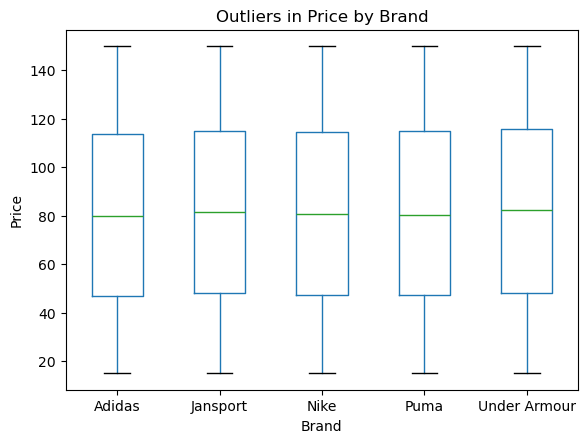

In [161]:
plt.figure(figsize=(10, 6))
df_train.boxplot(column=target_variable, by='Brand', grid=False)
plt.title(f"Outliers in {target_variable} by Brand")
plt.suptitle("")  # Removes the default matplotlib title
plt.ylabel(target_variable)
plt.xlabel('Brand')
plt.show()

<Figure size 1000x600 with 0 Axes>

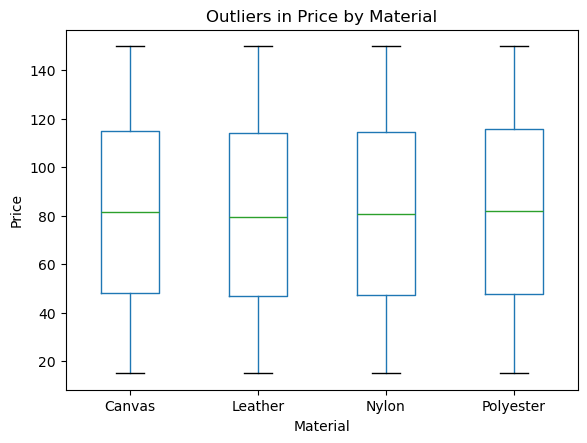

In [162]:
plt.figure(figsize=(10, 6))
df_train.boxplot(column=target_variable, by='Material', grid=False)
plt.title(f"Outliers in {target_variable} by Material")
plt.suptitle("")  # Removes the default matplotlib title
plt.ylabel(target_variable)
plt.xlabel('Material')
plt.show()

<Figure size 1000x600 with 0 Axes>

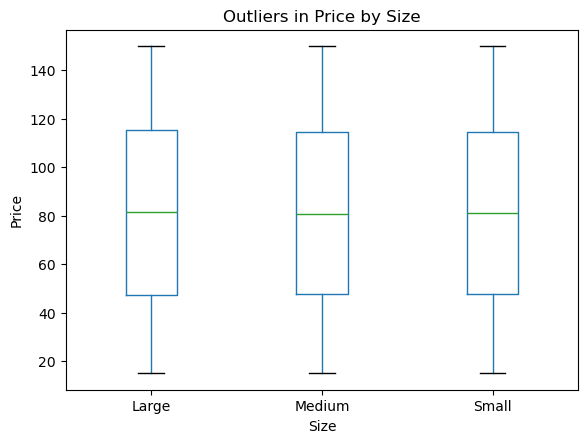

In [163]:
plt.figure(figsize=(10, 6))
df_train.boxplot(column=target_variable, by='Size', grid=False)
plt.title(f"Outliers in {target_variable} by Size")
plt.suptitle("")  # Removes the default matplotlib title
plt.ylabel(target_variable)
plt.xlabel('Size')
plt.show()

<Figure size 1000x600 with 0 Axes>

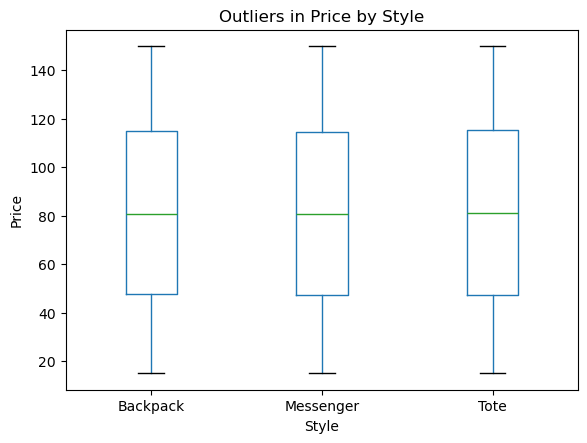

In [164]:
plt.figure(figsize=(10, 6))
df_train.boxplot(column=target_variable, by='Style', grid=False)
plt.title(f"Outliers in {target_variable} by Style")
plt.suptitle("")  # Removes the default matplotlib title
plt.ylabel(target_variable)
plt.xlabel('Style')
plt.show()

<Figure size 1000x600 with 0 Axes>

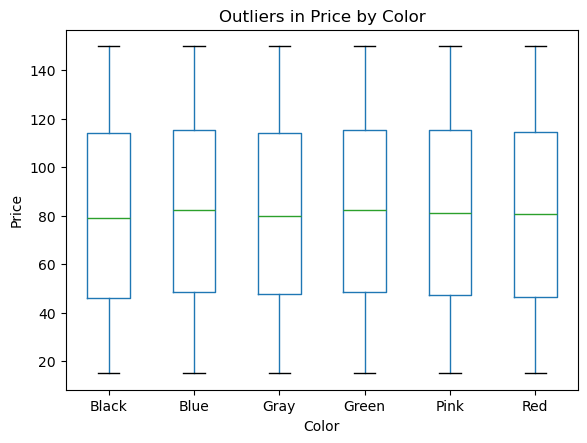

In [165]:
plt.figure(figsize=(10, 6))
df_train.boxplot(column=target_variable, by='Color', grid=False)
plt.title(f"Outliers in {target_variable} by Color")
plt.suptitle("")  # Removes the default matplotlib title
plt.ylabel(target_variable)
plt.xlabel('Color')
plt.show()

In [166]:
# Log to compress outliers
# df_train['y'] = np.log(df_train[target_variable])
# df_train = df_train.drop(target_variable, axis=1)

In [167]:
def clean_dataframe(df_to_use: pd.DataFrame, impute_num_nulls: bool = True, fill_cat_nulls: bool = True) -> None:
    df = df_to_use.copy()
    
    # Filter columns where the type is either 'float' or 'int' and there are missing values
    numeric_cols = df.select_dtypes(include=['number']).columns
    missing_numeric_columns = [
        col for col in numeric_cols if df[col].isnull().sum() > 0
    ]

    # Target field 'num_sold' is missing some values, we do not want to impute them
    if target_variable in missing_numeric_columns:
        missing_numeric_columns.remove(target_variable)
    
    # Fill nulls in numeric columns with the median
    if impute_num_nulls:       
        for column in missing_numeric_columns:
            mdn = df[column].median()
            df[column] = df[column].fillna(mdn)

    
    # Get category columns
    if fill_cat_nulls:
        cat_cols = df.select_dtypes(include=['object', 'string','category']).columns.tolist()  
        # Fill missing values in object columns
        for column in cat_cols:
            df[column] = df[column].fillna('None')
    
    return df

In [168]:
df_train = clean_dataframe(df_train, impute_num_nulls = True, fill_cat_nulls=False)
df_test = clean_dataframe(df_test, impute_num_nulls = True, fill_cat_nulls=False)

In [169]:
describe_dataframe(df_train, name='Backpack Data', nrows=0, plots=False, info=True)

,column,type,missing,pct_missing,unique,duplicate,count,min,max,avg,std dev,top value,Freq
0,id,int64,0,0.000000,3994318,0,3994318,0.000000,4194317.000000,2182137.162190,1178057.976858,nan,nan
1,Brand,object,126758,3.173458,5,0,3994318,nan,nan,nan,nan,Under Armour,801035
2,Material,object,110962,2.777996,4,0,3994318,nan,nan,nan,nan,Polyester,1060882
3,Size,object,87785,2.197747,3,0,3994318,nan,nan,nan,nan,Medium,1354487
4,Compartments,float64,0,0.000000,10,0,3994318,1.000000,10.000000,5.434740,2.893043,nan,nan
5,Laptop Compartment,object,98533,2.466829,2,0,3994318,nan,nan,nan,nan,Yes,1972937
6,Waterproof,object,94324,2.361454,2,0,3994318,nan,nan,nan,nan,Yes,1969205
7,Style,object,104180,2.608205,3,0,3994318,nan,nan,nan,nan,Messenger,1329677
8,Color,object,133617,3.345177,6,0,3994318,nan,nan,nan,nan,Pink,688257
9,Weight Capacity (kg),float64,0,0.000000,1920345,0,3994318,5.000000,30.000000,18.010437,6.972391,nan,nan


In [170]:
df_train = df_train.rename(columns={target_variable: 'y'})

In [171]:
# Transform Dataframes
def transform_df(df):
    df = df.rename(columns={'Laptop Compartment': 'Laptop_Compartment', 'Weight Capacity (kg)': 'Weight_Capacity'})
    df['Test_Col'] = df[['Material','Size','Color']].astype(str).agg('_'.join, axis=1)
    return df

df_train = transform_df(df_train)
df_test = transform_df(df_test)


In [172]:
df_train.columns

Index(['id', 'Brand', 'Material', 'Size', 'Compartments', 'Laptop_Compartment',
       'Waterproof', 'Style', 'Color', 'Weight_Capacity', 'y', 'Test_Col'],
      dtype='object')

In [173]:
RMV = ['y','id']
FEATURES = [c for c in df_train.columns if not c in RMV]
combined = pd.concat([df_train,df_test],axis=0,ignore_index=True)

CATS = []
HIGH_CARDINALITY = []
print(f"THE {len(FEATURES)} BASIC FEATURES ARE:")

for c in FEATURES:
    ftype = "numerical"
    if combined[c].dtype=="object":
        CATS.append(c)
        combined[c] = combined[c].fillna("NAN")
        combined[c],_ = combined[c].factorize()
        combined[c] -= combined[c].min()
        ftype = "categorical"
    if combined[c].dtype=="int64":
        combined[c] = combined[c].astype("int32")
    elif combined[c].dtype=="float64":
        combined[c] = combined[c].astype("float32")

    n = combined[c].nunique()
    print(f"{c} ({ftype}) with {n} unique values")
    if n>=9: HIGH_CARDINALITY.append(c)
    
df_train = combined.iloc[:len(df_train)].copy()
df_test = combined.iloc[len(df_train):].reset_index(drop=True).copy()

print("\nTHE FOLLOWING HAVE 9 OR MORE UNIQUE VALUES:", HIGH_CARDINALITY )


df_train = df_train.drop(['id'], axis=1)
df_test = df_test.drop(['id'], axis=1)


THE 10 BASIC FEATURES ARE:
Brand (categorical) with 6 unique values
Material (categorical) with 5 unique values
Size (categorical) with 4 unique values
Compartments (numerical) with 10 unique values
Laptop_Compartment (categorical) with 3 unique values
Waterproof (categorical) with 3 unique values
Style (categorical) with 4 unique values
Color (categorical) with 7 unique values
Weight_Capacity (numerical) with 944375 unique values
Test_Col (categorical) with 140 unique values

THE FOLLOWING HAVE 9 OR MORE UNIQUE VALUES: ['Compartments', 'Weight_Capacity', 'Test_Col']


In [174]:
describe_dataframe(df_train, name='Backpack Data', nrows=0, plots=False, info=True)

,column,type,missing,pct_missing,unique,duplicate,count,min,max,avg,std dev
0,Brand,int32,0,0.000000,6,0,3994318,0.000000,5.000000,2.097417,1.477653
1,Material,int32,0,0.000000,5,0,3994318,0.000000,4.000000,1.843959,1.506528
2,Size,int32,0,0.000000,4,0,3994318,0.000000,3.000000,1.033392,0.868584
3,Compartments,float32,0,0.000000,10,0,3994318,1.000000,10.000000,5.434737,2.873955
4,Laptop_Compartment,int32,0,0.000000,3,0,3994318,0.000000,2.000000,0.530732,0.546253
5,Waterproof,int32,0,0.000000,3,0,3994318,0.000000,2.000000,0.540231,0.543701
6,Style,int32,0,0.000000,4,0,3994318,0.000000,3.000000,1.333292,1.226483
7,Color,int32,0,0.000000,7,0,3994318,0.000000,6.000000,2.678889,1.796662
8,Weight_Capacity,float32,0,0.000000,915955,0,3994318,5.000000,30.000000,18.010437,6.958634
9,y,float64,0,0.000000,48358,0,3994318,15.000000,150.000000,81.362175,38.938684


In [175]:
import matplotlib.pyplot as plt
import numpy as np

def plot_feature_histograms(df, bins=20):
    """
    Plots histograms for all numerical features in the dataframe.
    
    Parameters:
    df (pd.DataFrame): Input DataFrame
    bins (int): Number of bins for histograms (default: 20)
    """
    numerical_features = df.select_dtypes(include=[np.number]).columns  # Select numerical columns
    num_features = len(numerical_features)
    
    if num_features == 0:
        print("No numerical features found.")
        return
    
    cols = 4  # Number of histograms per row
    rows = (num_features // cols) + (num_features % cols > 0)  # Compute number of rows
    
    fig, axes = plt.subplots(rows, cols, figsize=(16, rows * 4))
    axes = axes.flatten()  # Flatten for easy iteration
    
    for i, feature in enumerate(numerical_features):
        axes[i].hist(df[feature].dropna(), bins=bins, edgecolor='black', alpha=0.7)
        axes[i].set_title(f"Distribution of {feature}")
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel("Frequency")
    
    # Hide unused subplots
    for i in range(num_features, len(axes)):
        fig.delaxes(axes[i])
    
    plt.tight_layout()
    plt.show()

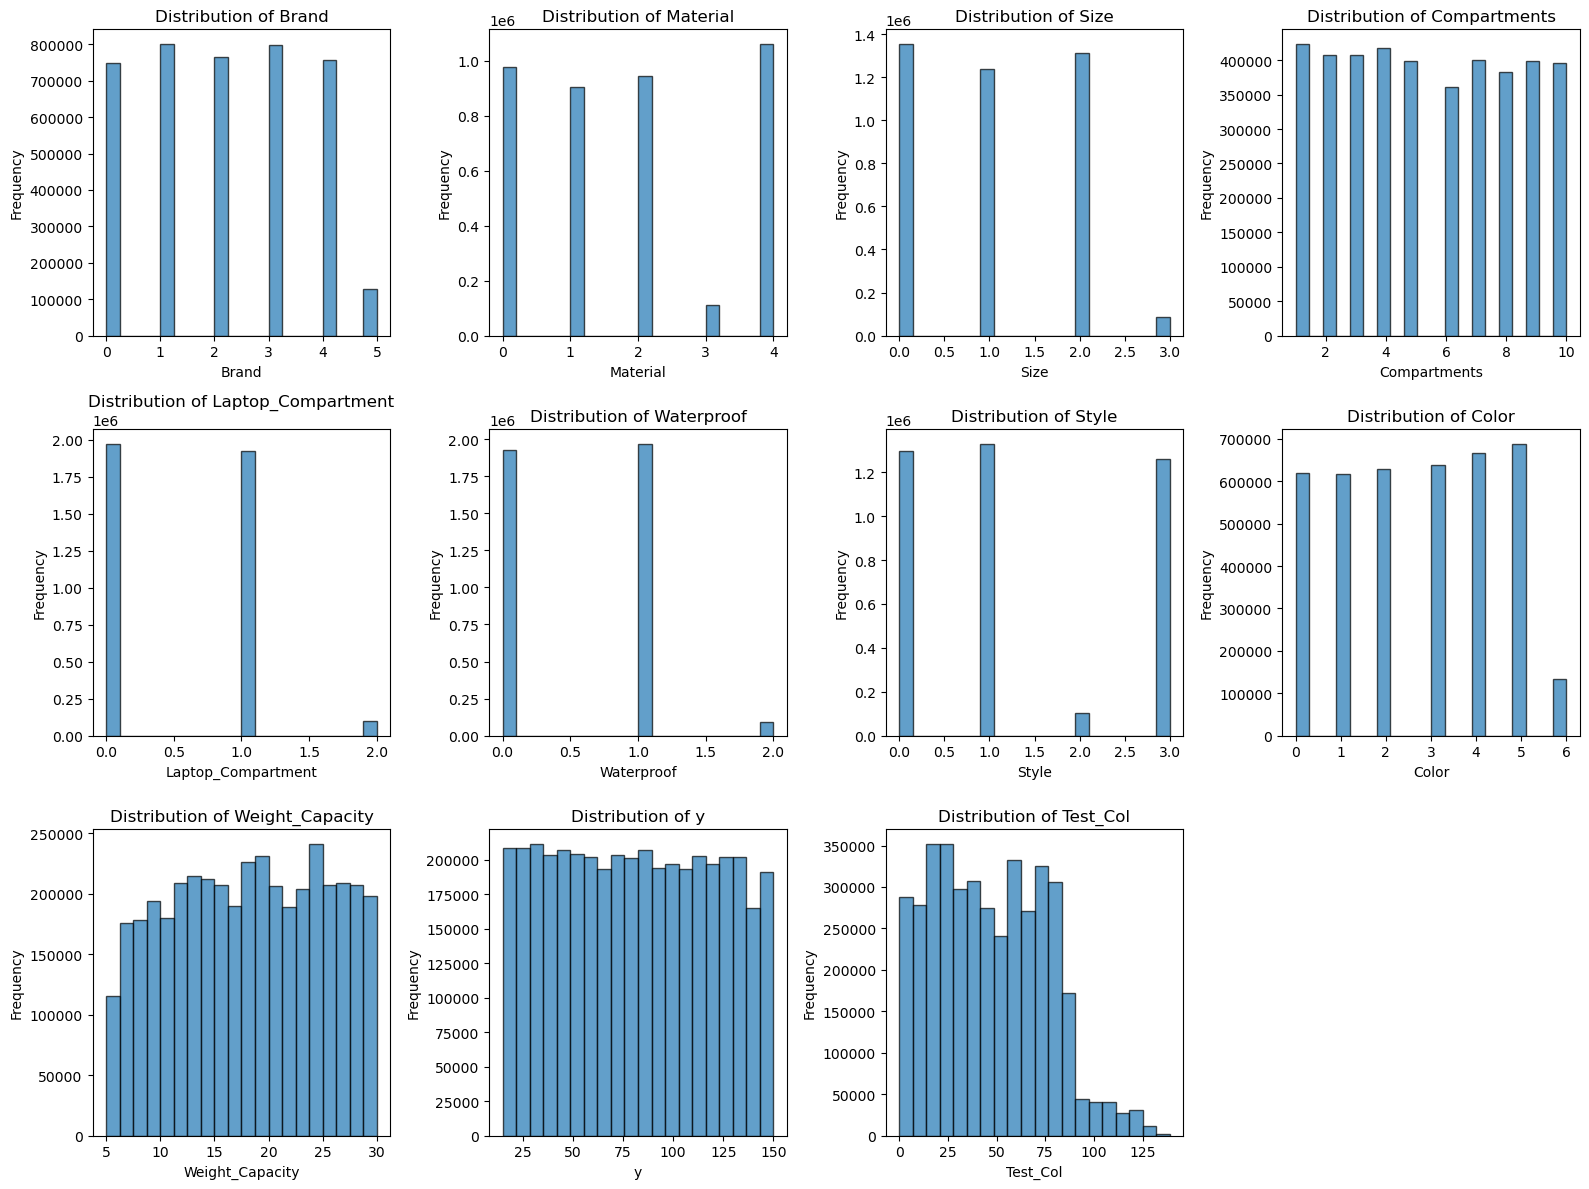

In [176]:
plot_feature_histograms(df_train)

In [177]:
def target_encode(train, valid, test, col, target="y", kfold=5, smooth=20, agg="mean"):
             
    train['kfold'] = ((train.index) % kfold)
    col_name = '_'.join(col)
    train[f'TE_{agg.upper()}_' + col_name] = 0.
    for i in range(kfold):
        
        df_tmp = train[train['kfold']!=i]       
        if agg=="mean": mn = train[target].mean()
        elif agg=="median": mn = train[target].median()
        elif agg=="min": mn = train[target].min()
        elif agg=="max": mn = train[target].max()
        elif agg=="nunique": mn = 0
        df_tmp = df_tmp[col + [target]].groupby(col).agg([agg, 'count']).reset_index()
        df_tmp.columns = col + [agg, 'count']
        if agg=="nunique":
            df_tmp['TE_tmp'] = df_tmp[agg] / df_tmp['count']
        else:
            df_tmp['TE_tmp'] = ((df_tmp[agg]*df_tmp['count'])+(mn*smooth)) / (df_tmp['count']+smooth)
        df_tmp_m = train[col + ['kfold', f'TE_{agg.upper()}_' + col_name]].merge(df_tmp, how='left', left_on=col, right_on=col)
        df_tmp_m.loc[df_tmp_m['kfold']==i, f'TE_{agg.upper()}_' + col_name] = df_tmp_m.loc[df_tmp_m['kfold']==i, 'TE_tmp']
        train[f'TE_{agg.upper()}_' + col_name] = df_tmp_m[f'TE_{agg.upper()}_' + col_name].fillna(mn).values  
    
    df_tmp = train[col + [target]].groupby(col).agg([agg, 'count']).reset_index()
    if agg=="mean": mn = train[target].mean()
    elif agg=="median": mn = train[target].median()
    elif agg=="min": mn = train[target].min()
    elif agg=="max": mn = train[target].max()
    elif agg=="nunique": mn = 0
    df_tmp.columns = col + [agg, 'count']
    
    if agg=="nunique":
        df_tmp['TE_tmp'] = df_tmp[agg] / df_tmp['count']
    else:
        df_tmp['TE_tmp'] = ((df_tmp[agg]*df_tmp['count'])+(mn*smooth)) / (df_tmp['count']+smooth)
        
    valid_col_df = valid[col]
    df_tmp_m = valid_col_df.merge(df_tmp, how='left', left_on=col, right_on=col).reset_index(drop=True)
    valid[f'TE_{agg.upper()}_' + col_name] = df_tmp_m['TE_tmp'].fillna(mn).values
    valid[f'TE_{agg.upper()}_' + col_name] = valid[f'TE_{agg.upper()}_' + col_name].astype("float32")
    
    test_col_df = test[col]
    df_tmp_m = test_col_df.merge(df_tmp, how='left', left_on=col, right_on=col).reset_index(drop=True)
    test[f'TE_{agg.upper()}_' + col_name] = df_tmp_m['TE_tmp'].fillna(mn).values
    test[f'TE_{agg.upper()}_' + col_name] = test[f'TE_{agg.upper()}_' + col_name].astype("float32")

    train = train.drop('kfold', axis=1)
    train[f'TE_{agg.upper()}_' + col_name] = train[f'TE_{agg.upper()}_' + col_name].astype("float32")

    return(train, valid, test)

In [178]:
# lists2 = [['Annual Income', 'Health Score'], ['Credit Score', 'Health Score'], ['Customer Feedback', 'Gender', 'Marital Status', 'Occupation', 'Smoking Status', 'year'], ['Exercise Frequency', 'Health Score'], ['Health Score', 'Marital Status'], ['Education Level', 'Gender', 'Health Score'], ['Health Score', 'Occupation'], ['Age', 'Health Score'], ['Health Score', 'dow'], ['Age', 'Exercise Frequency', 'Location'], ['Health Score', 'Smoking Status', 'month'], ['Health Score', 'Location', 'Policy Type'], ['Health Score', 'Insurance Duration'], ['Health Score', 'Number of Dependents'], ['Customer Feedback', 'Exercise Frequency', 'Previous Claims', 'Property Type', 'dow'], ['Customer Feedback', 'Health Score'], ['Health Score', 'Property Type'], ['Health Score', 'day', 'seconds'], ['Health Score', 'year'], ['Age', 'Gender', 'Insurance Duration', 'year']]
# print(f"We have {len(lists2)} powerful combination of columns!")
# print(lists2)
lists2 = []

In [179]:
import time
from xgboost import XGBRegressor
import xgboost as xgb, time
print(f"Using XGBoost version",xgb.__version__)


start = time.time()

FOLDS = 5
from sklearn.model_selection import KFold
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=SEED)

oof = np.zeros(len(df_train))
pred = np.zeros(len(df_test))

for i, (train_index, test_index) in enumerate(kf.split(df_train)):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)
    
    x_train = df_train.loc[train_index,FEATURES+["y"] ].copy()
    y_train = df_train.loc[train_index,"y"]
    x_valid = df_train.loc[test_index,FEATURES].copy()
    y_valid = df_train.loc[test_index,"y"]
    x_test = df_test[FEATURES].copy()

    start = time.time()
    print(f"FEATURE ENGINEER {len(FEATURES)} COLUMNS and {len(lists2)} GROUPS: ",end="")
    for j,f in enumerate(FEATURES+lists2):

        if j<len(FEATURES): c = [f]
        else: c = f 
        print(f"({j+1}){c}",", ",end="")

        # LOW CARDINALITY FEATURES - TARGET ENCODE MEAN AND MEDIAN
        x_train, x_valid, x_test = target_encode(x_train, x_valid, x_test, c, smooth=20, agg="mean")
        x_train, x_valid, x_test = target_encode(x_train, x_valid, x_test, c, smooth=0, agg="median")

        # HIGH CARDINALITY FEATURES - TE MIN, MAX, NUNIQUE and CE
        if (j>=len(FEATURES)) | (c[0] in HIGH_CARDINALITY):
            x_train, x_valid, x_test = target_encode(x_train, x_valid, x_test, c, smooth=0, agg="min")
            x_train, x_valid, x_test = target_encode(x_train, x_valid, x_test, c, smooth=0, agg="max")
            x_train, x_valid, x_test = target_encode(x_train, x_valid, x_test, c, smooth=0, agg="nunique")
    
            # COUNT ENCODING (USING COMBINED TRAIN TEST)
            tmp = combined.groupby(c).y.count() # Count y values for each group in the column
            nm = f"CE_{'_'.join(c)}"; tmp.name = nm # Set a name for the tmp series created above
            # Merge count column for each group
            x_train = x_train.merge(tmp, on=c, how="left")
            x_valid = x_valid.merge(tmp, on=c, how="left")
            x_test = x_test.merge(tmp, on=c, how="left")
            # Conver to int
            x_train[nm] = x_train[nm].astype("int32")
            x_valid[nm] = x_valid[nm].astype("int32")
            x_test[nm] = x_test[nm].astype("int32")
            
    end = time.time()
    elapsed = end-start
    print(f"Feature engineering took {elapsed:.1f} seconds")
    x_train = x_train.drop("y",axis=1)
    
    model_folds = XGBRegressor(
        device=device,
        max_depth=8,
        colsample_bytree=0.9, 
        subsample=0.9, 
        n_estimators=2_000,
        learning_rate=0.01, 
        early_stopping_rounds=50,  
        eval_metric="rmse",
    )
    model_folds.fit(
        x_train, y_train,
        eval_set=[(x_valid, y_valid)],   
        verbose=100
    )

    # INFER OOF
    oof[test_index] = model_folds.predict(x_valid)
    # INFER TEST
    pred += model_folds.predict(x_test)

    m = np.sqrt(np.mean( (y_valid.to_numpy() - oof[test_index])**2.0 )) 
    print(f" => Fold {i+1} RMSLE = {m:.5f}")
    
# COMPUTE AVERAGE TEST PREDS
pred /= FOLDS

Using XGBoost version 2.1.4
#########################
### Fold 1
#########################
FEATURE ENGINEER 10 COLUMNS and 0 GROUPS: (1)['Brand'] , (2)['Material'] , (3)['Size'] , (4)['Compartments'] , (5)['Laptop_Compartment'] , (6)['Waterproof'] , (7)['Style'] , (8)['Color'] , (9)['Weight_Capacity'] , (10)['Test_Col'] , Feature engineering took 214.4 seconds


D:\Users\ZCHODANIECKY\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:23:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
D:\Users\ZCHODANIECKY\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:23:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[0]	validation_0-rmse:38.92588
[100]	validation_0-rmse:38.73161
[200]	validation_0-rmse:38.69389
[300]	validation_0-rmse:38.68361
[400]	validation_0-rmse:38.67915
[500]	validation_0-rmse:38.67648
[600]	validation_0-rmse:38.67508
[700]	validation_0-rmse:38.67464
[800]	validation_0-rmse:38.67389
[867]	validation_0-rmse:38.67386
 => Fold 1 RMSLE = 38.67374
#########################
### Fold 2
#########################
FEATURE ENGINEER 10 COLUMNS and 0 GROUPS: (1)['Brand'] , (2)['Material'] , (3)['Size'] , (4)['Compartments'] , (5)['Laptop_Compartment'] , (6)['Waterproof'] , (7)['Style'] , (8)['Color'] , (9)['Weight_Capacity'] , (10)['Test_Col'] , Feature engineering took 210.8 seconds


D:\Users\ZCHODANIECKY\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:39:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
D:\Users\ZCHODANIECKY\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:39:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[0]	validation_0-rmse:38.93723
[100]	validation_0-rmse:38.74199
[200]	validation_0-rmse:38.70499
[300]	validation_0-rmse:38.69436
[400]	validation_0-rmse:38.69012
[500]	validation_0-rmse:38.68742
[600]	validation_0-rmse:38.68646
[673]	validation_0-rmse:38.68613
 => Fold 2 RMSLE = 38.68606
#########################
### Fold 3
#########################
FEATURE ENGINEER 10 COLUMNS and 0 GROUPS: (1)['Brand'] , (2)['Material'] , (3)['Size'] , (4)['Compartments'] , (5)['Laptop_Compartment'] , (6)['Waterproof'] , (7)['Style'] , (8)['Color'] , (9)['Weight_Capacity'] , (10)['Test_Col'] , Feature engineering took 200.8 seconds


D:\Users\ZCHODANIECKY\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:51:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
D:\Users\ZCHODANIECKY\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:51:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[0]	validation_0-rmse:38.91792
[100]	validation_0-rmse:38.72853
[200]	validation_0-rmse:38.69334
[300]	validation_0-rmse:38.68345
[400]	validation_0-rmse:38.67904
[500]	validation_0-rmse:38.67657
[600]	validation_0-rmse:38.67505
[700]	validation_0-rmse:38.67461
[764]	validation_0-rmse:38.67483
 => Fold 3 RMSLE = 38.67452
#########################
### Fold 4
#########################
FEATURE ENGINEER 10 COLUMNS and 0 GROUPS: (1)['Brand'] , (2)['Material'] , (3)['Size'] , (4)['Compartments'] , (5)['Laptop_Compartment'] , (6)['Waterproof'] , (7)['Style'] , (8)['Color'] , (9)['Weight_Capacity'] , (10)['Test_Col'] , Feature engineering took 201.0 seconds


D:\Users\ZCHODANIECKY\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:04:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
D:\Users\ZCHODANIECKY\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:04:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[0]	validation_0-rmse:38.94979
[100]	validation_0-rmse:38.75833
[200]	validation_0-rmse:38.72074
[300]	validation_0-rmse:38.71046
[400]	validation_0-rmse:38.70649
[500]	validation_0-rmse:38.70342
[600]	validation_0-rmse:38.70184
[700]	validation_0-rmse:38.70110
[786]	validation_0-rmse:38.70117
 => Fold 4 RMSLE = 38.70101
#########################
### Fold 5
#########################
FEATURE ENGINEER 10 COLUMNS and 0 GROUPS: (1)['Brand'] , (2)['Material'] , (3)['Size'] , (4)['Compartments'] , (5)['Laptop_Compartment'] , (6)['Waterproof'] , (7)['Style'] , (8)['Color'] , (9)['Weight_Capacity'] , (10)['Test_Col'] , Feature engineering took 201.0 seconds


D:\Users\ZCHODANIECKY\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:18:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
D:\Users\ZCHODANIECKY\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:18:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[0]	validation_0-rmse:38.94060
[100]	validation_0-rmse:38.75282
[200]	validation_0-rmse:38.71775
[300]	validation_0-rmse:38.70791
[400]	validation_0-rmse:38.70333
[500]	validation_0-rmse:38.70069
[600]	validation_0-rmse:38.69908
[700]	validation_0-rmse:38.69813
[800]	validation_0-rmse:38.69787
[836]	validation_0-rmse:38.69787
 => Fold 5 RMSLE = 38.69760


In [180]:
describe_dataframe(x_train, name='Backpack Data', nrows=0, plots=False, info=True)

,column,type,missing,pct_missing,unique,duplicate,count,min,max,avg,std dev
0,Brand,int32,0,0.000000,6,27,3195455,0.000000,5.000000,2.096561,1.477502
1,Material,int32,0,0.000000,5,27,3195455,0.000000,4.000000,1.844156,1.506635
2,Size,int32,0,0.000000,4,27,3195455,0.000000,3.000000,1.033363,0.868704
3,Compartments,float32,0,0.000000,10,27,3195455,1.000000,10.000000,5.434145,2.879266
4,Laptop_Compartment,int32,0,0.000000,3,27,3195455,0.000000,2.000000,0.530814,0.546197
5,Waterproof,int32,0,0.000000,3,27,3195455,0.000000,2.000000,0.540439,0.543734
6,Style,int32,0,0.000000,4,27,3195455,0.000000,3.000000,1.333869,1.226617
7,Color,int32,0,0.000000,7,27,3195455,0.000000,6.000000,2.679322,1.796523
8,Weight_Capacity,float32,0,0.000000,793595,27,3195455,5.000000,30.000000,18.008234,6.961963
9,Test_Col,int32,0,0.000000,140,27,3195455,0.000000,139.000000,46.409006,28.721372


In [181]:
# #####
# # Try Bayesian Optimization
# #### 
# from sklearn.model_selection import GridSearchCV
# from skopt import BayesSearchCV
# from xgboost import XGBRegressor

# # Hyperparameters for BayesSearchCV tuning
# search_spaces = {
#     'n_estimators': (500, 1500),      
#     'max_depth': (3, 12),            
#     'reg_alpha': (0.001, 0.2, 'log-uniform'),  
#     'reg_lambda': (0.1, 100, 'log-uniform')     
# }

# # Leave some cores available
# available_cores = os.cpu_count()
# n_cores = max(1, available_cores - 3)  # Leave 3 cores free


# xgb = XGBRegressor(random_state=SEED)

# # Set up BayesSearchCV for hyperparameter tuning
# grid_search = BayesSearchCV(
#     estimator=xgb,
#     search_spaces=search_spaces,
#     n_iter=25,          # Number of iterations for optimization
#     cv=5,               # k-fold cross-validation
#     verbose=1,          # Display detailed logs
#     scoring="neg_root_mean_squared_error",
#     random_state=SEED     
# )

# if skip_hypertuning:

#     best_params = {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 1200}

# else:
#     start_time = time.time()
    
#     grid_search.fit(x_train, y_train)
    
#     end_time = time.time()  
    
#     best_params = grid_search.best_params_
#     best_rmse = (-grid_search.best_score_) ** 0.5
    
#     print("Best parameters:",best_params)
#     print("Best RMSE:", best_rmse)

#     # Calculate elapsed time in minutes
#     elapsed_time_minutes = (end_time - start_time) / 60
#     print(f"Elapsed time: {elapsed_time_minutes:.2f} minutes")

In [182]:

# # Initialize the XGBRegressor
# model_bayes = XGBRegressor(
#     **best_params,
#     random_state=SEED,        # Ensure reproducibility
#     objective='reg:squarederror'
# )

# # Train the model
# model_bayes.fit(
#     x_train, 
#     y_train, 
#     eval_set=[(x_valid, y_valid)],
#     verbose=100
# )

In [183]:
m = np.sqrt(np.mean( (df_train['y'].values - oof)**2.0 )) 
print(f"Overall CV RMSLE = {m:.5f}")

Overall CV RMSLE = 38.68659


In [184]:
# Overall CV RMSLE = 38.68659

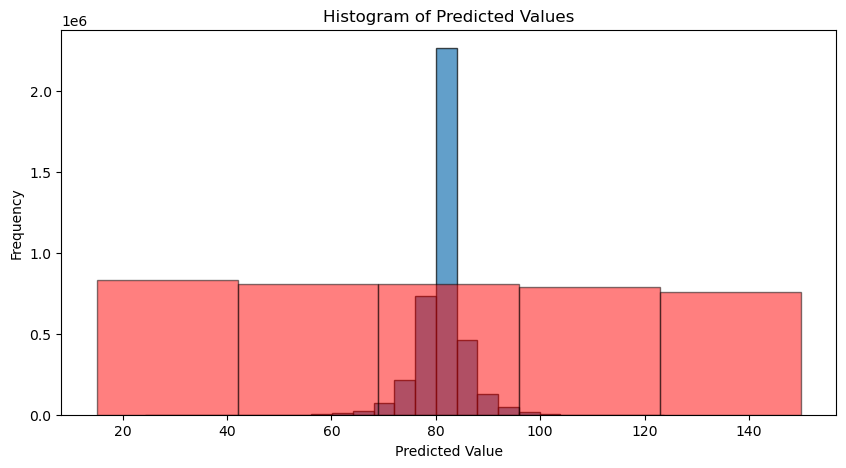

In [243]:
import matplotlib.pyplot as plt

# Plot histogram
plt.figure(figsize=(10, 5))
plt.hist(oof, bins=25, edgecolor='black', alpha=0.7)
plt.hist(df_train['y'].values, bins=5, alpha=0.5, label="Predicted Values", color="red", edgecolor="black")

# Labels and title
plt.xlabel("Predicted Value")
plt.ylabel("Frequency")
plt.title("Histogram of Predicted Values")

# Show plot
plt.show()

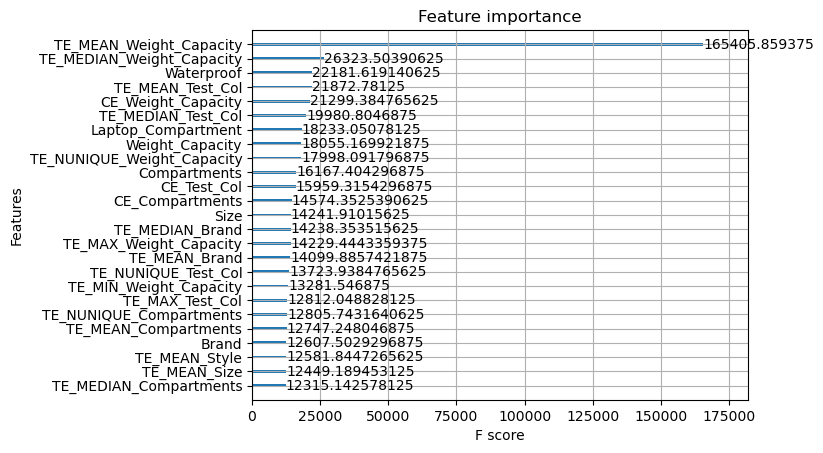

In [185]:
from xgboost import plot_importance

#Plot feature importance
plot_importance(model_folds, importance_type='gain', max_num_features=25)  
# 'weight', 'gain', 'cover' are possible importance types
plt.show()

In [186]:
# Predict on test set
y_test_pred = model_bayes.predict(x_test)

In [187]:
sub = pd.read_csv(submission_path)
sub[target_variable] = y_test_pred
sub.to_csv('Predictions_XGBoost.csv', index=False)
print(sub.shape)
sub.head()

(200000, 2)


,id,Price
0,300000,81.606972
1,300001,82.671265
2,300002,83.149490
3,300003,79.070404
4,300004,79.764381
